<h1> Behavirol Cloning Project </h1>

As part of the Udacity Self Driving Car Course, implemented this project to train a car to drive around the track. The project at higher level mainly consist of two parts.
1. Collect data for training the Convolutional Neural Network (CNN)
2. Augment, Pre Process the data collected and build a CNN to drive the car autonomosly

<h2> Step 1: Data Collection </h2>
Used the data collected from Udacity website for track 1, run the simulator in Training mode and collect data as needed.

<h2> Step 2: Data Pre-processing </h2>
Prepare data for training. Listed below are the steps followed for preparing data for training,
1. **Crop the image:** After viewing the images as seen in some of the below cells, the reason to crop the top and bottom 20 pixels is taken in order to get rid some part of the sky image and the hood of the car from training.
2. **Resize the image:** The images are resized to (80, 80)
3. **Augmenting/transformation:** As part of training the car to behave correctly in case where it might try to wonder off the street, we create additional data and labels (with the expected behavior) for the training model to learn the correct behavior. Some of the methods involved in augmenting the existing data are:
**Flipping** - Flipping the image creates additional data for training
**Vertical/Horizontal shift** - Vertical/Horizontal shifting also creates additional data for training. Vertical shifting of the image does help traing for uphill/downhill cases.
**Alter Brightnees** -  Altering the brightness helps train the network for some cases of shadow and/or for different times of day.

The left and right images provide a lot of information as well. Added, +0.25 angle to left image and -0.25 angle to right image

The website listed did give a good read for data augmentation:
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

4. **Normalize: ** Finally applied normalized the image between -0.5 to +0.5 value

Below code shows some of the Pre Processing steps and its results:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.preprocessing.image import img_to_array, load_img, flip_axis, random_shift
from PIL.ImageEnhance import Brightness, Color, Contrast, Sharpness
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/driving_log.csv')

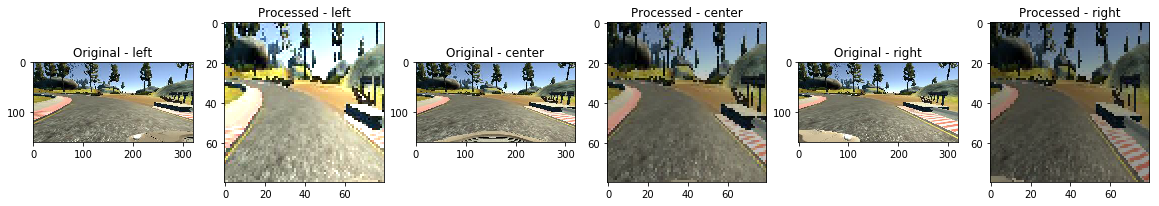

In [3]:
def crop_image(image, enable = 1):
    if enable:
        return image.crop((0, 20, image.size[0], image.size[1] - 20))
    else:
        return image

def apply_modify(image, function, low = 0.5, high = 1.5):
    factor = np.random.uniform(low, high)
    enhancer = function(image)
    return enhancer.enhance(factor)

def random_shift_mod(image, angle, wrg = 0.0, hrg = 0.0):
    h, w = image.size
    tx = np.random.uniform(-wrg, wrg) * w
    ty = np.random.uniform(-hrg, hrg) * h
    angle = angle + (tx / h) * 0.4
    image = np.asarray(image)
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty]])
    image = cv2.warpAffine(image, translation_matrix, (h, w))
    return image, angle

def preprocess_train_image(image):
    image = crop_image(image)
    image = image.resize((80, 80))
    image = apply_modify(image, Brightness)
    return image


fig = plt.figure(figsize=(20, 20))
for i in range(0, 1):
    j = 0
    #index = np.random.randint(len(df) - 1)
    index = 14
    
    for l in ['left', 'center', 'right']:
        j = j + 1
        location = df.loc[index, [l]][0]
        plt.subplot(1,6, (i*3)+j)
        image = Image.open('data/' + location.strip())
        plt.title("Original - %s" % l)
        plt.imshow(image)
        
        j = j + 1
        image = preprocess_train_image(image)
        plt.subplot(1,6, (i*3)+j)
        plt.title("Processed - %s" % l)
        plt.imshow(image)

<h2> Step 3: Model Architecture</h2>

We used Nvidia model for this project. The Nvidia CNN model is very well defined in the below link:
https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

The architecture used in the our model has 5 Convolutional layers, with each convolution layer followed with MaxPooling layer, followed by 3 fully connected layers. The complete CNN network is as below:

Layer 1 - Convolution, Output filters: 24, filter size = (5, 5), Activation: Exponential Linear Unit (ELU)
        - MaxPooling, Pool size = (2, 2)

Layer 2 - Convolution, Output filters: 36, filter size = (5, 5), Activation: Exponential Linear Unit (ELU)
        - MaxPooling, Pool size = (2, 2)

Layer 3 - Convolution, Output filters: 48, filter size = (5, 5), Activation: Exponential Linear Unit (ELU)
        - MaxPooling, Pool size = (2, 2)
        
Layer 4 - Convolution, Output filters: 64, filter size = (3, 3), Activation: Exponential Linear Unit (ELU)
        - MaxPooling

Layer 5 - Convolution, Output filters: 64, filter size = (3, 3), Activation: Exponential Linear Unit (ELU)
        - MaxPooling

Flatten

Layer 6 - Fully Connected - Size: 1164, Activation: Exponential Linear Unit (ELU)
        - Dropout (0.5)

Layer 7 - Fully Connected - Size: 100, Activation: Exponential Linear Unit (ELU)
        - Dropout (0.5)

Layer 8 - Fully Connected - Size: 50, Activation: Exponential Linear Unit (ELU)
        - Dropout (0.5)
        
Layer 9 - Fully Connected - Size: 10, Activation: Exponential Linear Unit (ELU)
        - Dropout (0.5)

Output Layer - Size: 1 Activation: Linear


We add Dropout layer with each Fully Connected layers in order to avoid Overfitting. Below is the code for the Nvidia CNN model.

In [4]:
def get_model(shape):

    model = Sequential()
    #model.add(BatchNormalization(mode=2, axis=1, input_shape=shape))
    model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='elu',
                            input_shape=(shape[0], shape[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='elu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='elu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(Flatten())

    model.add(Dense(1164, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))

    return model

<h2> Step 4: Model Training </h2>

We trained the model using the keras fit_generator. The fit_generator does help reduce memory consumption significantly. We choose a batch size of 256 and epoch of 3. We explored a lot of different combinations of batch size and epoch. Based on the performance we ended up choosing 256 & 3 respectively. The number of sampler per epoch is choosen close to 20480, which is ~2x the original training data.

The training model is optimized for 'loss' metric. Keras 'Adam' Optimizer is used with default learning rate (0.001).
Below is the code for the training generator and the training code.

In [5]:
def validation_generator(test_data, test_labels):
    while True:
        index = np.random.randint(len(test_data) - 1)
        images = test_data[index]
        angles = test_labels[index]

        index2 = np.random.randint(3)

        x = load_img(images[index2])
        x = preprocess_test_image(x)
        x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        y = np.array([[angles[index2]]])

        yield x, y


def training_generator(batch_size, train_data, train_labels):

    while True:
        x = []
        y = []

        for i in range(batch_size):
            index = np.random.randint(len(train_data) - 1)

            images = train_data[index]
            angles = train_labels[index]

            index2 = np.random.randint(3)
            image, angle = load_and_process_image(images[index2], angles[index2])

            x.append(image)
            y.append(angle)

        yield np.array(x), np.array(y)


def train_model():
    #
    # Generate training data
    features, labels = process_image_dir()
    print("Data generate done: %d" % len(features))

    #
    # Generating training and testing data
    features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                labels,
                                                                                test_size=0.2,
                                                                                random_state=42)
    #
    # Get model & compile
    model = get_model(new_image_shape)
    adam = Adam(lr=0.001)
    model.compile(loss='mse', optimizer='adam')

    print("Model compiled")

    model.fit_generator(training_generator(256, features_train, labels_train),
                        samples_per_epoch=20480,
                        nb_epoch=2,
                        verbose=1,
                        callbacks=[],
                        validation_data=validation_generator(features_test, labels_test),
                        nb_val_samples=len(features_test))

    with open("model.json", "w") as fp:
        json.dump(model.to_json(), fp)

    model.save_weights("model.h5", overwrite=True)

<h2> Final Results and Learnings: </h2>

The model took ~25 mins to train. Below is the log:




Learnings:
1. Collecting data for training is a significant task.
2. Data pre-processing is significantly important for reducing the training time as well as increasing the accuracy. Identifyng what data to be used training, what needs to discarded plays key role in reducing training time and improving accuracy
3. Use GPU for training the model. I do not have a CUDA enabled GPU and training the model took several minutes. Each iteration took close to ~ 30 mins. Hence exploration/optimzation time was significnatly reduced